In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, AdamW
import torch

import keras
from keras import models,layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences

2023-09-07 22:24:56.320943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df = pd.read_csv("dataset8.csv")

In [5]:
device = torch.device("cpu")

In [6]:
# Define tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Download model with pretrained weights 
model_bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
model_bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [7]:
# BERT EMBEDDINGS - Function

# get embeddings for all words in sentences
def embeddings(sentences):
    
    # Add the special tokens with encode plus.
    encoding = tokenizer.encode_plus(sentences, add_special_tokens = True, truncation=True, padding=True,return_attention_mask= True, return_tensors="pt") 

    tokens_tensor = encoding["input_ids"] 
    segments_tensors = encoding["attention_mask"] 
    segments_ids = encoding["token_type_ids"]
    
    with torch.no_grad():

        outputs = model_bert(tokens_tensor.to(device), segments_tensors.to(device)) #fit the vectors into the moedel

    hidden_states = outputs[2] #extraction of hidden states
    
    
    del outputs   #free gpu --- freeing GPU we avoid CUDA out of memory problem on the server.
    

    token_embeddings = torch.stack(hidden_states, dim=0) # torch.Size([13, 1, 73, 768])
    
    token_embeddings = torch.squeeze(token_embeddings, dim=1) #torch.Size([13, 73, 768])
    
    token_embeddings = token_embeddings.permute(1,0,2) #torch.Size([73, 13, 768])
    
    #Extracting CLS embedding
    cls_emb = token_embeddings[0][-4:].mean(dim=0).detach().cpu().numpy() #Extraction of CLS embeddings

    # Alternatively we store the token vectors
    sent_token_vecs_sum = []

    # For each token in the sentence...
    for token in token_embeddings:
        tok = token.to("cpu")   #feed into a cpu
        token.detach() #deletion of the token in GPU 
        del token  

        # Sum last four layers.
        sum_vec = torch.sum(tok[-4:], dim=0)

        sent_token_vecs_sum.append(sum_vec)

    b_emb = torch.stack(sent_token_vecs_sum, dim=0).mean(dim=0).detach().cpu().numpy() #Extraction of the summed embeddings
        
    return cls_emb, b_emb

## Creates Embeddings

In [8]:
prompts = df.prompts.to_list()
responses = df.responses.to_list()

summed_embeddings_p = []
cls_embeddings_p = []

summed_embeddings_res = []
cls_embeddings_res = []


for idx in tqdm(range(0, len(prompts)), desc ="Creating prompts embeddings"):
    cls_emb_p, b_emb_p = embeddings(prompts[idx])
    summed_embeddings_p.append(b_emb_p)
    cls_embeddings_p.append(cls_emb_p)
    
for idx in tqdm(range(0, len(responses)), desc ="Creating response embeddings"):
    cls_emb_r, b_emb_r = embeddings(responses[idx])
    summed_embeddings_res.append(b_emb_r)
    cls_embeddings_res.append(cls_emb_r)

Creating response embeddings: 100%|██████████| 32/32 [03:15<00:00,  6.11s/it]


In [9]:
#  Create embeddings for prompts and responses combined
from functools import reduce

both = reduce(lambda i, j: i + [j[0] +" "+ j[1]], zip(prompts, responses),[])
print(both[0])

summed_embeddings_b = []
cls_embeddings_b = []

for idx in tqdm(range(0, len(both)), desc ="Creating combined embeddings"):
    cls_emb_b, b_emb_b = embeddings(both[idx])
    summed_embeddings_b.append(b_emb_b)
    cls_embeddings_b.append(cls_emb_b)

You just heard the surprising news that Adam's date has an artificial leg. You bump into him and ask him how the date went. He replies restlessly: "Great. It was great. She is, uh, she is great, great looking, great personality, she is greatness." "Oh so the date was 'greatness' all around, huh? Sounds like you have truly 'legendary' time!"


Creating combined embeddings: 100%|██████████| 32/32 [03:49<00:00,  7.16s/it]


## Training

In [10]:
# The function for training and plotting the validation loss
# We use the mean squared error (MSE) for the loss and mean absolute error (MAE) for the metrics because we are dealing with a regression problem 

def train(model, X_train, y_train):
    model.compile(optimizer='adamax', loss='mse', metrics=['mae'])  
    history = model.fit(X_train, y_train,
                    epochs=12,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=1)
    
    # Plot the loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return history

### Prompts embeddings

In [11]:
#arrange indices 

indices = np.arange(np.array(summed_embeddings_p).shape[0])
np.random.shuffle(indices)
summed_embeddings, sarc = np.array(summed_embeddings_p), np.array(df.sarcasm) #transform into np array

summed_embeddings_p = summed_embeddings[indices]
sarc = sarc[indices]


# split data
p_train, p_test, y_train, y_test = train_test_split(summed_embeddings_p, sarc, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

(25,) (7,)


In [12]:
# prompt model

model = Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(768,)))  #model processes batches where each sample has shape(768,).
model.add(layers.Dense(64, activation='relu'))

#model.add(layers.Dropout(0.2)) #weight regularization -- reduce overfitting
#The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant

model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
# The 'None' in the tensor shapes represents the batch size: the model allows batches of any size


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 6152      
                                                                 
 dense_1 (Dense)             (None, 64)                576       
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,793
Trainable params: 6,793
Non-trainable params: 0
_________________________________________________________________


2023-09-07 22:36:30.261472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 22:36:32.484189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14489 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:44:00.0, compute capability: 7.5
2023-09-07 22:36:32.490885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3584 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:a3:00.0, compute capability: 7.5
2023-09-07 22:36:32.492510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with

Epoch 1/12


2023-09-07 22:36:55.937884: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55d4b8592b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-07 22:36:55.937956: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-09-07 22:36:55.937961: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2023-09-07 22:36:55.937964: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Quadro RTX 5000, Compute Capability 7.5
2023-09-07 22:36:55.956798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-07 22:36:56.082493: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-07 22:36:56.149045: I tensorflow

2/2 [==============================] - 2s 205ms/step - loss: 0.8061 - mae: 0.7088 - val_loss: 0.6860 - val_mae: 0.5474
Epoch 2/12
2/2 [==============================] - 0s 72ms/step - loss: 0.6934 - mae: 0.6371 - val_loss: 0.6106 - val_mae: 0.4827
Epoch 3/12
2/2 [==============================] - 0s 45ms/step - loss: 0.6237 - mae: 0.5932 - val_loss: 0.5766 - val_mae: 0.4503
Epoch 4/12
2/2 [==============================] - 0s 40ms/step - loss: 0.5847 - mae: 0.5691 - val_loss: 0.5633 - val_mae: 0.4444
Epoch 5/12
2/2 [==============================] - 0s 43ms/step - loss: 0.5650 - mae: 0.5580 - val_loss: 0.5599 - val_mae: 0.4434
Epoch 6/12
2/2 [==============================] - 0s 56ms/step - loss: 0.5627 - mae: 0.5561 - val_loss: 0.5587 - val_mae: 0.4432
Epoch 7/12
2/2 [==============================] - 0s 41ms/step - loss: 0.5617 - mae: 0.5563 - val_loss: 0.5576 - val_mae: 0.4429
Epoch 8/12
2/2 [==============================] - 0s 37ms/step - loss: 0.5605 - mae: 0.5560 - val_loss: 0.5

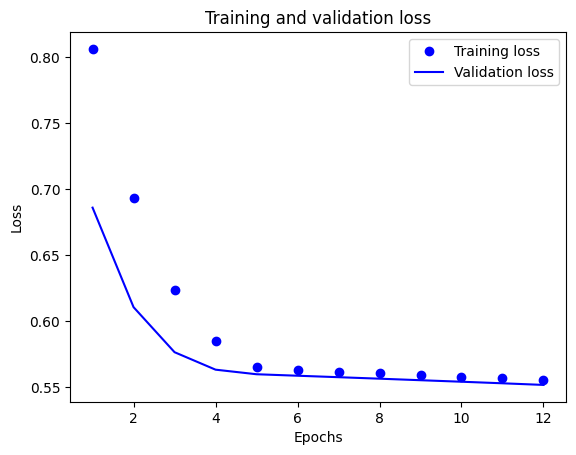

In [13]:
history_prompt = train(model, p_train, y_train)

In [15]:
model.evaluate(p_test, y_test)

1/1 [==============================] - 0s 64ms/step - loss: 0.8186 - mae: 0.6586


[0.8186175227165222, 0.6586325764656067]

### Training with Responses Embeddings

In [16]:
#responses -- sarcasm

indices = np.arange(np.array(summed_embeddings_res).shape[0])
np.random.shuffle(indices)
summed_embeddings_r, sarc = np.array(summed_embeddings_res), np.array(df.sarcasm) #transform into np array

summed_embeddings_r = summed_embeddings_r[indices]
sarc = sarc[indices]

# split for train and validation data
r_train, r_test, y_train, y_test = train_test_split(summed_embeddings_r, sarc, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

(25,) (7,)


In [17]:
# Defining the model for responses
model2 = Sequential()

model2.add(layers.Dense(8, activation='relu', input_shape=(768,)))
model2.add(layers.Dense(64, activation='relu'))
#model2.add(layers.Dropout(0.2))

model2.add(layers.Dense(1, activation='sigmoid'))

#model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])#tried rmsprop, adagrad but adamax seems better
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 6152      
                                                                 
 dense_4 (Dense)             (None, 64)                576       
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,793
Trainable params: 6,793
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
2/2 [==============================] - 1s 146ms/step - loss: 0.6583 - mae: 0.6081 - val_loss: 0.1324 - val_mae: 0.2958
Epoch 2/12
2/2 [==============================] - 0s 84ms/step - loss: 0.5908 - mae: 0.5763 - val_loss: 0.1020 - val_mae: 0.2722
Epoch 3/12
2/2 [==============================] - 0s 54ms/step - loss: 0.5441 - mae: 0.5688 - val_loss: 0.0828 - val_mae: 0.2624
Epoch 4/12
2/2 [==============================] - 0s 46ms/step - loss: 0.5051 - mae: 0.5534 - val_loss: 0.0721 - val_mae: 0.2554
Epoch 5/12
2/2 [==============================] - 0s 39ms/step - loss: 0.4742 - mae: 0.5408 - val_loss: 0.0666 - val_mae: 0.2499
Epoch 6/12
2/2 [==============================] - 0s 46ms/step - loss: 0.4566 - mae: 0.5394 - val_loss: 0.0642 - val_mae: 0.2453
Epoch 7/12
2/2 [==============================] - 0s 54ms/step - loss: 0.4374 - mae: 0.5313 - val_loss: 0.0638 - val_mae: 0.2422
Epoch 8/12
2/2 [==============================] - 0s 57ms/step - loss: 0.4271 - mae: 0.5317 - va

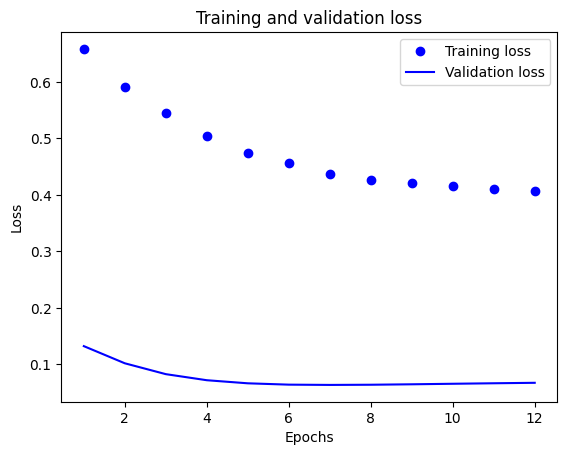

In [18]:
history_response = train(model2, r_train, y_train)

In [20]:
model2.evaluate(r_test, y_test)

1/1 [==============================] - 0s 38ms/step - loss: 0.4890 - mae: 0.5068


[0.4889867603778839, 0.506750226020813]

In [21]:
# combined -- sarcasm
# combined emmbeddings -- sarc
indices = np.arange(np.array(summed_embeddings_b).shape[0])
np.random.shuffle(indices)
summed_embeddings_both, sarc = np.array(summed_embeddings_b), np.array(df.sarcasm) #transform into np array

sum_embeddings_both = summed_embeddings_both[indices]
sarc = sarc[indices]

# split for train and validation data
b_train, b_test, y_train, y_test = train_test_split(sum_embeddings_both, sarc, test_size=0.2, random_state=42)

print(y_train.shape, y_test.shape)

(25,) (7,)


In [22]:
# Defining the model for both
model3 = Sequential()


model3.add(layers.Dense(8, activation='relu', input_shape=(768,)))

model3.add(layers.Dense(64, activation='relu'))
#model3.add(LSTM(8)) #input dim = 2

model3.add(layers.Dense(1, activation='sigmoid'))

#model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])#tried rmsprop, adagrad but adamax seems better
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 6152      
                                                                 
 dense_7 (Dense)             (None, 64)                576       
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,793
Trainable params: 6,793
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
2/2 [==============================] - 1s 174ms/step - loss: 0.6396 - mae: 0.5826 - val_loss: 1.7523 - val_mae: 1.1433
Epoch 2/12
2/2 [==============================] - 0s 57ms/step - loss: 0.5041 - mae: 0.4848 - val_loss: 1.5683 - val_mae: 1.0644
Epoch 3/12
2/2 [==============================] - 0s 59ms/step - loss: 0.4388 - mae: 0.4465 - val_loss: 1.4533 - val_mae: 1.0134
Epoch 4/12
2/2 [==============================] - 0s 42ms/step - loss: 0.4047 - mae: 0.4285 - val_loss: 1.3515 - val_mae: 0.9674
Epoch 5/12
2/2 [==============================] - 0s 42ms/step - loss: 0.3760 - mae: 0.4182 - val_loss: 1.2701 - val_mae: 0.9261
Epoch 6/12
2/2 [==============================] - 0s 40ms/step - loss: 0.3590 - mae: 0.4136 - val_loss: 1.2045 - val_mae: 0.8913
Epoch 7/12
2/2 [==============================] - 0s 50ms/step - loss: 0.3442 - mae: 0.4093 - val_loss: 1.1521 - val_mae: 0.8626
Epoch 8/12
2/2 [==============================] - 0s 44ms/step - loss: 0.3313 - mae: 0.4032 - va

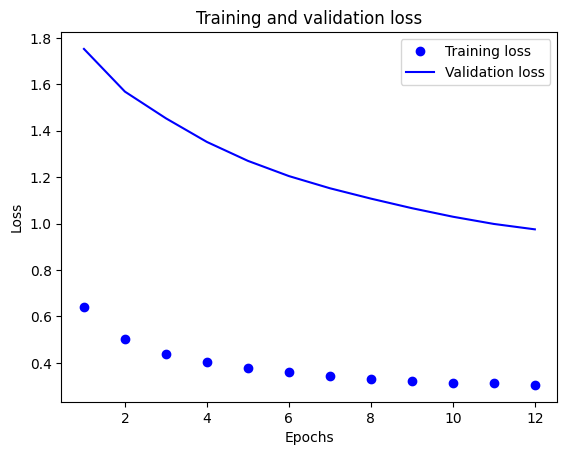

In [23]:
history_both = train(model3, b_train, y_train)

In [24]:
model3.evaluate(b_test, y_test)

1/1 [==============================] - 0s 28ms/step - loss: 0.2584 - mae: 0.4802


[0.258404016494751, 0.48019498586654663]